# Conditioning and Guidance 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import DataLoader
from smalldiffusion import TreeDataset, training_loop, samples, ScheduleLogLinear, ConditionalMLP
from torch.utils.data import Dataset
from itertools import pairwise
from pathlib import Path
from tqdm import tqdm

def plot_batch(batch, ax=None, **kwargs):
    batch = batch.cpu().numpy()
    ax = ax or plt
    return ax.scatter(batch[:,0], batch[:,1], marker='.', **kwargs)
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w   

class MultiClassSwissroll(Dataset):
    def __init__(self, tmin, tmax, N, num_classes=10, center=(0,0), scale=1.0):

        self.num_classes = num_classes
        
        t = tmin + torch.linspace(0, 1, N) * tmax
        center = torch.tensor(center).unsqueeze(0)
        spiral_points = center + scale * torch.stack([t*torch.cos(t)/tmax, t*torch.sin(t)/tmax]).T
        
        # Assign classes based on position along the spiral
        # Divide the parameter range into num_classes segments
        class_boundaries = torch.linspace(tmin, tmax, num_classes + 1)
        classes = torch.zeros(N, dtype=torch.long)
        
        for i in range(N):
            # t[i] is already the actual parameter value we want to use for class assignment
            t_val = t[i]
            # Find which segment t_val falls into (0 to num_classes-1)
            class_idx = min(int((t_val - tmin) / (tmax - tmin) * num_classes), num_classes - 1)
            classes[i] = class_idx
        
        # Store data as list of (point, class) tuples
        self.data = [(spiral_points[i], classes[i].item()) for i in range(N)]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def get_class_colors(self):
        """
        Returns a list of colors evenly sampled from a colorwheel (HSV space).
        """
        import matplotlib.colors as mcolors
        
        # Generate evenly spaced hues around the color wheel
        hues = np.linspace(0, 1, self.num_classes, endpoint=False)
        colors = []
        
        for hue in hues:
            # Convert HSV to RGB (saturation=1, value=1 for vibrant colors)
            rgb = mcolors.hsv_to_rgb([hue, 1.0, 1.0])
            colors.append(rgb)
        
        return colors


In [2]:
dataset = MultiClassSwissroll(np.pi/2, 5*np.pi, 100, num_classes=3)
colors = dataset.get_class_colors()
loader = DataLoader(dataset, batch_size=len(dataset)*2, shuffle=True)

In [3]:
x, labels = next(iter(loader))
x=x.cpu().numpy()

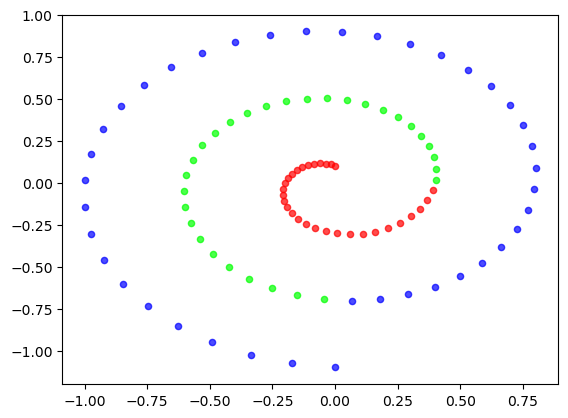

In [4]:
for class_idx in range(dataset.num_classes):
    mask = labels == class_idx
    class_points = x[mask]
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)

In [5]:
labels

tensor([1, 0, 2, 1, 2, 1, 2, 0, 2, 0, 2, 0, 1, 0, 2, 1, 1, 1, 2, 2, 1, 0, 1, 2,
        2, 2, 2, 2, 2, 0, 0, 2, 0, 1, 0, 2, 1, 2, 1, 2, 1, 1, 2, 0, 2, 0, 1, 0,
        2, 2, 0, 1, 2, 2, 0, 0, 0, 2, 0, 0, 1, 0, 1, 1, 0, 2, 0, 1, 2, 2, 1, 0,
        1, 2, 1, 1, 2, 1, 0, 0, 2, 1, 1, 1, 0, 2, 0, 2, 2, 1, 0, 0, 2, 1, 2, 0,
        2, 2, 2, 2])

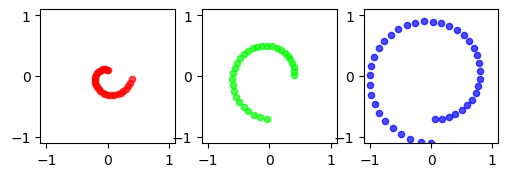

In [6]:
fig=plt.figure(0, (8,8))
for class_idx in range(dataset.num_classes):
    mask = labels == class_idx
    class_points = x[mask]
    fig.add_subplot(4,4,class_idx+1)
    plt.scatter(class_points[:, 0], class_points[:, 1], 
               c=[colors[class_idx]], label=f'Class {class_idx}', 
               alpha=0.7, s=20)
    plt.xlim([-1.1,1.1]); plt.ylim([-1.1, 1.1])

In [7]:
model = ConditionalMLP(dim=2, hidden_dims=(16, 128, 256, 128, 16), cond_dim=4, num_classes=dataset.num_classes)
schedule = ScheduleLogLinear(N=200, sigma_min=0.01, sigma_max=10)
trainer = training_loop(loader, model, schedule, epochs=30000, lr=1e-3, conditional=True)
losses = [ns.loss.item() for ns in trainer]

100%|████████████████████████████████| 30000/30000 [04:34<00:00, 109.41it/s]


- Ok, what visualizations do I want here to support my writing? Probably something like:

1. Probably DDIM sampling - different colored flow lines by class - no guidance yes
2. Explore how conditioning on class impacts vectors fields (different colored arrows on top of eachother? maybe with fewer classes)
3. Guidance for sure - lines trailing particles for different guidance levels - and let's give a little thought to the geometry! 
4. Ok for geometry, I think i want to visualize the conditioned and unconditioned vector fields on top of each other right? That could be a pretty slick animation!
5. Bonus points for visualizing the conditioned vector field w/ a "negative" class ("i really don't want it to be x") - this will be cool too - ok let's get it!

## 1. Probably DDIM sampling - different colored flow lines by class - no guidance yet

In [8]:
bound=1.5
num_heatmap_steps=30
grid=[]
for i, x in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
    for j, y in enumerate(np.linspace(-bound, bound, num_heatmap_steps)):
        grid.append([x,y])
grid=torch.tensor(grid).float()

In [9]:
grid.shape

torch.Size([900, 2])

In [10]:
# Generalizes most commonly-used samplers:
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
#   Accelerated: gam=2, mu=0

N_sample=64 #Crank to 256 for nice viz? I guess I'll probably be re-doing this on the manim side, so I can crank there
sample_batch_size=100
gam=1.0
cfg_scale=0.0 # 0 means no classifier-free guidance
mu=0.0
batchsize=sample_batch_size

results_by_class=[]
xt_history=[]
heatmaps=[]
for c in range(dataset.num_classes):
    sigmas=schedule.sample_sigmas(N_sample)
    cond=torch.tensor([c for _ in range(sample_batch_size)])
    cond_grid=torch.tensor([c for _ in range(len(grid))])
    xt_history.append([])
    heatmaps.append([])
    with torch.no_grad():
        model.eval()
        xt = model.rand_input(batchsize).to('cuda') * sigmas[0]
        if cond is not None:
            assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
            cond = cond.to(xt.device)
        eps = None
        for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
            eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
            eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
            sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
            eta = (sig_prev**2 - sig_p**2).sqrt()
            xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
            
            xt_history[-1].append(xt.cpu().numpy())
            # heatmaps[-1].append(model.forward(grid, sig.to('cuda'), cond=cond))
            heatmaps[-1].append(model.predict_eps_cfg(grid.to('cuda'), sig.to(xt), cond_grid.to('cuda'), cfg_scale).cpu())

    xt_history[-1]=np.array(xt_history[-1])
    results_by_class.append(xt.cpu().numpy())

(-1.1, 1.1)

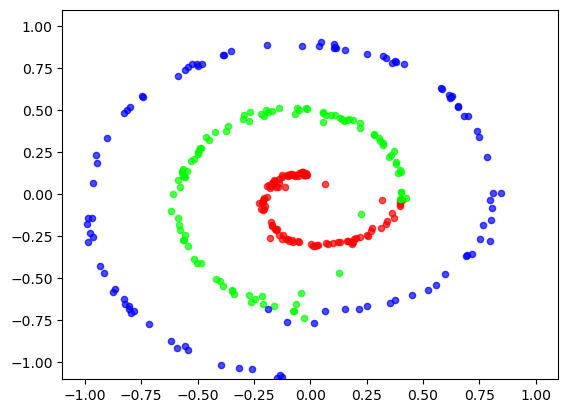

In [11]:
for class_idx in range(dataset.num_classes):
    plt.scatter(results_by_class[class_idx][:, 0], results_by_class[class_idx][:, 1], 
               c=[colors[class_idx]], alpha=0.7, s=20)
plt.xlim([-1.1,1.1]); plt.ylim([-1.1, 1.1])

In [12]:
save_dir=Path('/home/stephen/sora/jun_23_3')
save_dir.mkdir(exist_ok=True)

In [13]:
len(heatmaps)

3

In [14]:
len(heatmaps[0])

64

/tmp/ipykernel_23460/375758600.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xt_history[c][i,j,0], xt_history[c][i,j,1], alpha=0.7, s=8, c=colors[c])
/tmp/ipykernel_23460/375758600.py:3: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (7,7))
100%|███████████████████████████████████████| 64/64 [01:08<00:00,  1.07s/it]


<Figure size 640x480 with 0 Axes>

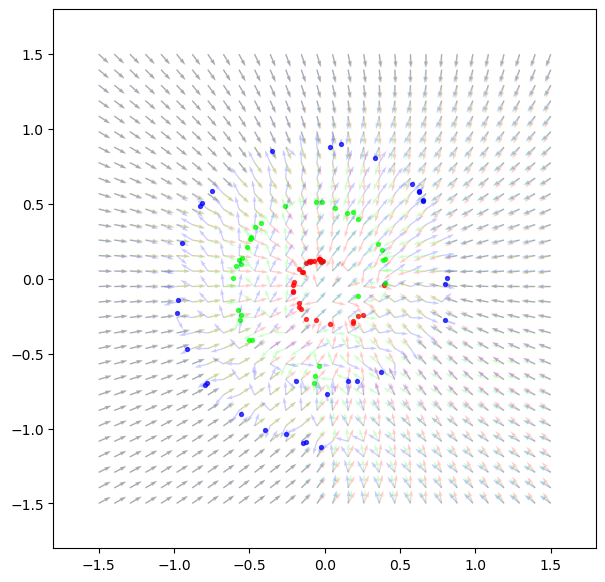

In [15]:
for i in tqdm(range(len(heatmaps[0]))):
    plt.clf()
    fig=plt.figure(0, (7,7))
        
    for c, h in enumerate(heatmaps):
        heatmap_norm=torch.nn.functional.normalize(h[i], p=2, dim=1)
        plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color=colors[c])
        
        for j in range(32): #Just do a subset of trajetories
            plt.plot(xt_history[c][np.maximum(i-10, 0):i+1,j,0], xt_history[c][np.maximum(i-10, 0):i+1,j,1], '-', alpha=0.2, color=tuple(colors[c]))
            plt.scatter(xt_history[c][i,j,0], xt_history[c][i,j,1], alpha=0.7, s=8, c=colors[c])
        
    viz_bounds=1.8
    plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
    plt.savefig(save_dir/(str(i)+'.png'), dpi=200)

## 2. Explore how conditioning on class impacts vectors fields (different colored arrows on top of eachother? maybe with fewer classes)
- Ok I think i'll just run again with different save paths and fewer classes?

In [16]:
save_dir=Path('/home/stephen/sora/jun_23_4')
save_dir.mkdir(exist_ok=True)

/tmp/ipykernel_23460/2373690246.py:3: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (7,7))
100%|███████████████████████████████████████| 64/64 [00:16<00:00,  3.78it/s]


<Figure size 640x480 with 0 Axes>

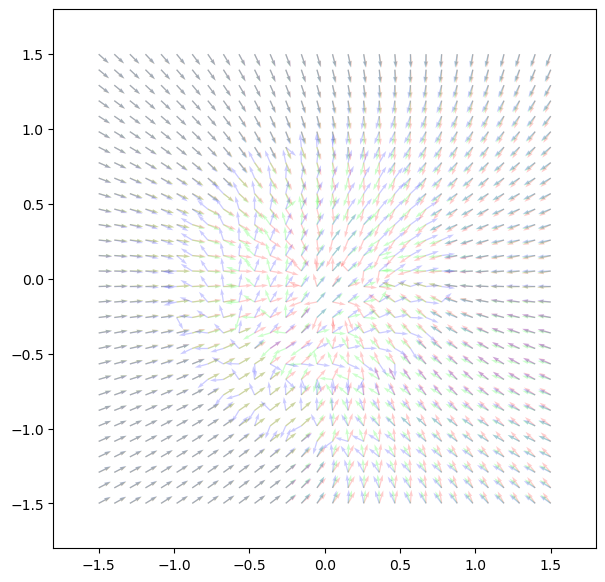

In [17]:
for i in tqdm(range(len(heatmaps[0]))):
    plt.clf()
    fig=plt.figure(0, (7,7))
        
    for c, h in enumerate(heatmaps):
        heatmap_norm=torch.nn.functional.normalize(h[i], p=2, dim=1)
        plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color=colors[c])
        
        # for j in range(32): #Just do a subset of trajetories
        #     plt.plot(xt_history[c][np.maximum(i-10, 0):i+1,j,0], xt_history[c][np.maximum(i-10, 0):i+1,j,1], '-', alpha=0.2, color=tuple(colors[c]))
        #     plt.scatter(xt_history[c][i,j,0], xt_history[c][i,j,1], alpha=0.7, s=8, c=colors[c])
        
    viz_bounds=1.8
    plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
    plt.savefig(save_dir/(str(i)+'.png'), dpi=200)

3. Guidance for sure - lines trailing particles for different guidance levels - and let's give a little thought to the geometry!

In [33]:
# Generalizes most commonly-used samplers:
#   DDPM       : gam=1, mu=0.5
#   DDIM       : gam=1, mu=0
#   Accelerated: gam=2, mu=0

N_sample=64 #Crank to 256 for nice viz? I guess I'll probably be re-doing this on the manim side, so I can crank there
sample_batch_size=100
gam=1.0
cfg_scale=0.0 # 0 means no classifier-free guidance
mu=0.0
batchsize=sample_batch_size

results_by_class=[]
xt_history=[]
heatmaps=[]
unconditioned_heatmaps=[]
conditioned_heatmaps=[]
cfg_scales=[0.0, 0.1, 0.5, 1.0, 2.0, 3.0, 5.0, 10.0]
c=2 #Just hack on a single class for now
for cfg_scale in cfg_scales:
    sigmas=schedule.sample_sigmas(N_sample)
    cond=torch.tensor([c for _ in range(sample_batch_size)])
    cond_grid=torch.tensor([c for _ in range(len(grid))])
    xt_history.append([])
    heatmaps.append([])
    unconditioned_heatmaps.append([])
    conditioned_heatmaps.append([])
    with torch.no_grad():
        model.eval()
        xt = model.rand_input(batchsize).to('cuda') * sigmas[0]
        if cond is not None:
            assert cond.shape[0] == xt.shape[0], 'cond must have same shape as x!'
            cond = cond.to(xt.device)
        eps = None
        for i, (sig, sig_prev) in enumerate(pairwise(sigmas)):
            eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), cond, cfg_scale)
            eps_av = eps * gam + eps_prev * (1-gam)  if i > 0 else eps
            sig_p = (sig_prev/sig**mu)**(1/(1-mu)) # sig_prev == sig**mu sig_p**(1-mu)
            eta = (sig_prev**2 - sig_p**2).sqrt()
            xt = xt - (sig - sig_p) * eps_av + eta * model.rand_input(xt.shape[0]).to(xt)
            
            xt_history[-1].append(xt.cpu().numpy())
            # heatmaps[-1].append(model.forward(grid, sig.to('cuda'), cond=cond))
            heatmaps[-1].append(model.predict_eps_cfg(grid.to('cuda'), sig.to(xt), cond_grid.to('cuda'), cfg_scale).cpu())

            #Uncoditioned and conditioned heatmaps let's go!
            uncond = torch.full_like(cond_grid.to('cuda'), model.cond_embed.null_cond) # (B,)
            eps_cond, eps_uncond = model.predict_eps(                  # (B,), (B,)
                torch.cat([grid.to('cuda'), grid.to('cuda')]), sig.to(xt), torch.cat([cond_grid.to('cuda'), uncond])   # (2B,)
            ).chunk(2)
            unconditioned_heatmaps[-1].append(eps_uncond.cpu())
            conditioned_heatmaps[-1].append(eps_cond.cpu())

    xt_history[-1]=np.array(xt_history[-1])
    results_by_class.append(xt.cpu().numpy())

- Ok first I think it makes sense to just compare the conditioned and uncoditioned heatmaps??
- Alright this is kinda subtle - I can kinda bake the conditioning into the heatmap or not...
- My intuition is that it might be cool to...
- Hmm so is guidance more about changing the trajectories or changing the vector field? I think vector field is maybe a good way to think about it. Obviously it will change the trajectories too - but the vector field angle has a nice simple goemetric interpretation!
- So now that I'm really thinking about it , I feel like i want to show 3 arrows? One for conditioned, one for unconditioned, and then one for the result of classifier free guidance?

In [34]:
save_dir=Path('/home/stephen/sora/jun_23_5')
save_dir.mkdir(exist_ok=True)

/tmp/ipykernel_23460/3766529472.py:6: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (7,7))
100%|█████████████████████████████████████████| 8/8 [02:18<00:00, 17.34s/it]


<Figure size 640x480 with 0 Axes>

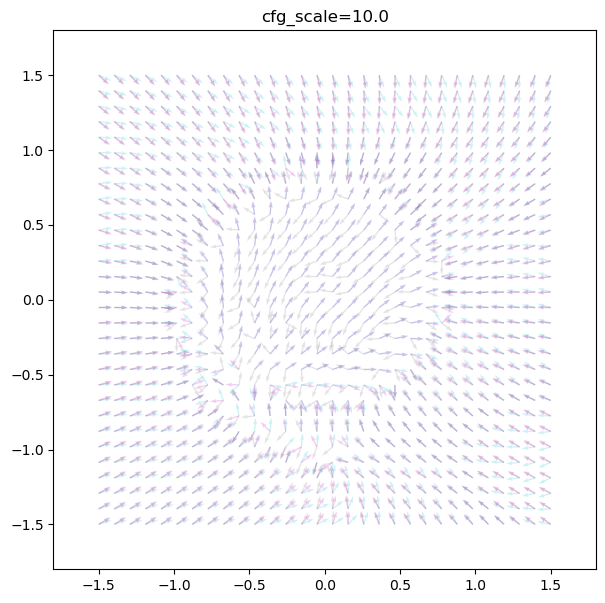

In [35]:
#Let's try different guidance levels sequentiall first.
count=0
for j, cfg_scale in enumerate(tqdm(cfg_scales)):
    for i in range(len(heatmaps[0])):
        plt.clf()
        fig=plt.figure(0, (7,7))
        plt.title('cfg_scale='+str(cfg_scale))
        
        heatmap_norm=torch.nn.functional.normalize(heatmaps[j][i], p=2, dim=1)
        plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color='c')

        heatmap_norm=torch.nn.functional.normalize(unconditioned_heatmaps[j][i], p=2, dim=1)
        plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color='#777777')

        heatmap_norm=torch.nn.functional.normalize(conditioned_heatmaps[j][i], p=2, dim=1)
        plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color='m')

            
        viz_bounds=1.8
        plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
        plt.savefig(save_dir/(str(count)+'.png'), dpi=200)
        count+=1

In [36]:
save_dir=Path('/home/stephen/sora/jun_23_6')
save_dir.mkdir(exist_ok=True)

/tmp/ipykernel_23460/3657130002.py:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xt_history[j][i,k,0], xt_history[j][i,k,1], alpha=0.7, s=8, c=colors[c])
/tmp/ipykernel_23460/3657130002.py:6: UserWarning: Ignoring specified arguments in this call because figure with num: 0 already exists
  fig=plt.figure(0, (7,7))
100%|█████████████████████████████████████████| 8/8 [05:11<00:00, 38.92s/it]


<Figure size 640x480 with 0 Axes>

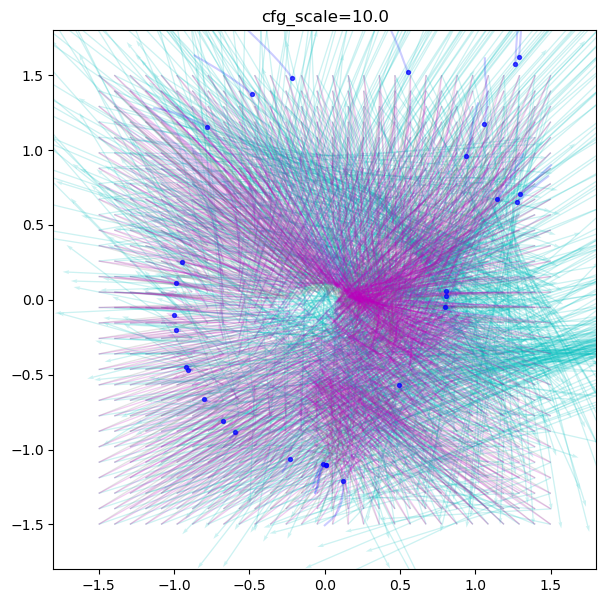

In [38]:
#Let's try different guidance levels sequentiall first.
count=0
for j, cfg_scale in enumerate(tqdm(cfg_scales)):
    for i in range(len(heatmaps[0])):
        plt.clf()
        fig=plt.figure(0, (7,7))
        plt.title('cfg_scale='+str(cfg_scale))
        
        # heatmap_norm=torch.nn.functional.normalize(heatmaps[j][i], p=2, dim=1)
        heatmap_norm=heatmaps[j][i]
        plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color='c')

        # heatmap_norm=torch.nn.functional.normalize(unconditioned_heatmaps[j][i], p=2, dim=1)
        heatmap_norm=unconditioned_heatmaps[j][i]
        plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color='#777777')

        # heatmap_norm=torch.nn.functional.normalize(conditioned_heatmaps[j][i], p=2, dim=1)
        heatmap_norm=conditioned_heatmaps[j][i]
        plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color='m')

        for k in range(32): #Just do a subset of trajetories
            plt.plot(xt_history[j][np.maximum(i-10, 0):i+1,k,0], xt_history[j][np.maximum(i-10, 0):i+1,k,1], '-', alpha=0.2, color=tuple(colors[c]))
            plt.scatter(xt_history[j][i,k,0], xt_history[j][i,k,1], alpha=0.7, s=8, c=colors[c])


        viz_bounds=1.8
        plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
        plt.savefig(save_dir/(str(count)+'.png'), dpi=200)
        count+=1

In [ ]:
for i in tqdm(range(len(heatmaps[0]))):
    plt.clf()
    fig=plt.figure(0, (7,7))

    # for cfg_scale in cfg_scales:
    for c, h in enumerate(heatmaps):
        heatmap_norm=torch.nn.functional.normalize(h[i], p=2, dim=1)
        plt.quiver(grid[:,0], grid[:,1], -heatmap_norm[:,0], -heatmap_norm[:,1], alpha=0.2,  scale=40, color=colors[c])
        
        # for j in range(32): #Just do a subset of trajetories
        #     plt.plot(xt_history[c][np.maximum(i-10, 0):i+1,j,0], xt_history[c][np.maximum(i-10, 0):i+1,j,1], '-', alpha=0.2, color=tuple(colors[c]))
        #     plt.scatter(xt_history[c][i,j,0], xt_history[c][i,j,1], alpha=0.7, s=8, c=colors[c])
        
    viz_bounds=1.8
    plt.xlim([-viz_bounds, viz_bounds]);  plt.ylim([-viz_bounds, viz_bounds])
    plt.savefig(save_dir/(str(i)+'.png'), dpi=200)

In [ ]:
# uncond = torch.full_like(cond, self.cond_embed.null_cond) # (B,)
# eps_cond, eps_uncond = self.predict_eps(                  # (B,), (B,)
#     torch.cat([x, x]), sigma, torch.cat([cond, uncond])   # (2B,)
# ).chunk(2)

In [19]:
model.cond_embed.null_cond

3